In [1]:
import pandas as pd

pd.set_option("display.precision", 3)
import os
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from ConsensusClusteringSingleView import ConsensusCluster
import scipy.stats as sps
import copy
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from tqdm import tqdm

from pathlib import Path
from itertools import product
import matplotlib.cm as cm
import matplotlib.lines as mlines
from ConsensusClusteringSingleView import ConsensusCluster

In [2]:
data_path = "data/"
kcc_path = "{}/KCC/".format(data_path)
score_path = "{}/ClusteringResults/".format(data_path)
cdf_path = "{}/CDF_plots/".format(data_path)
tsne_path = '{}/TSNE_plots/'.format(data_path)
refer_id = pd.read_csv("data/ContextualViewStandardized.csv", index_col=0)


In [ ]:
def plot_kmeans(view, KCC_space):
    report = pd.read_csv(
        "{}/ConsensusKMeans_{}_view.csv".format(score_path, view), index_col=0
    )
    report = report[report["KCC_space"] == KCC_space]
    report = report.sort_values("silhouette_score", ascending=False).iloc[0]
    data = pd.read_csv(
        "{}/KCC_Cov_AgeGRM_{}_NormalImputation_K{}.csv".format(
            kcc_path, view, KCC_space
        ),
        header=None,
    )
    display(report)

    cons = ConsensusCluster(
        KMeans, KCC_space, KCC_space + 1, 100, resample_proportion=0.8
    )
    perplexity, random_state = int(report["perplexity"]), int(report["random_state"])
    tsne = TSNE(perplexity=perplexity, random_state=random_state, n_components=2)
    X_emb = tsne.fit_transform(data.values)
    assert X_emb.shape == (358, 2)
    cons.fit(pd.DataFrame(X_emb))
    assignment = cons.predict_data(X_emb) + 1

    plt.figure(figsize=(12, 9))
    legends = []
    cmap = cm.rainbow(np.linspace(0, 1, KCC_space))
    colors = np.array([cmap[i - 1] for i in assignment])
    for i in range(KCC_space):
        legends.append(
            mlines.Line2D(
                [],
                [],
                color=cmap[i],
                marker=".",
                linestyle="None",
                markersize=10,
                label="Cluster {}".format(i + 1),
            )
        )
    plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        color=colors,
        s=10,
        marker="*",
    )
    plt.title(
        "KMeans: {} view, KCC space = {}".format(view, KCC_space),
        fontsize=20,
    )
    plt.legend(handles=legends, fontsize=10)
    plt.savefig(name, dpi=300)
    plt.show()

# KMeans CDF plot

In [8]:
for view in ["clinical", "contextual", "physio", "proteome"]:
    report = pd.read_csv(
        "{}/ConsensusKMeans_{}_view.csv".format(score_path, view), index_col=0
    )
    Mks = []
    for KCC_space in range(3, 11):
        data = pd.read_csv(
            "{}/KCC_Cov_AgeGRM_{}_NormalImputation_K{}.csv".format(
                kcc_path, view, KCC_space
            ),
            header=None,
        )
        assert data.shape == (358, KCC_space)
        report_sub = (
            report[report["KCC_space"] == KCC_space]
            .sort_values("silhouette_score", ascending=False)
            .iloc[0]
        )

        cons = ConsensusCluster(
            KMeans, KCC_space, KCC_space + 1, 100, resample_proportion=0.8
        )
        perplexity, random_state = int(report_sub["perplexity"]), int(
            report_sub["random_state"]
        )
        tsne = TSNE(perplexity=perplexity, random_state=random_state, n_components=2)
        X_emb = tsne.fit_transform(data.values)
        assert X_emb.shape == (358, 2)
        cons.fit(pd.DataFrame(X_emb))
        assignment = cons.predict_data(X_emb) + 1
        Mks.append(cons.Mk[0])

    Aks = []
    plt.figure(figsize=(20, 15))
    for KCC_space in range(3, 11):
        hist, bins = np.histogram(Mks[KCC_space - 3].ravel(), bins=50)
        pdf = hist / sum(hist)
        cdf = np.cumsum(pdf)
        acdf = np.sum(h * (b - a) for b, a, h in zip(bins[1:], bins[:-1], cdf))
        Aks.append(acdf)
        plt.plot(bins[1:], cdf, label=KCC_space)

    plt.legend(fontsize=16)
    plt.title("CDF: {} view".format(view), fontsize=25)

    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig(
        "{}/ConsensusKMeans_{}_view_KCC_{}.png".format(tsne_path, view, KCC_space),
        dpi=300,
    )
    plt.show()

KeyboardInterrupt: 

# best KMeans case

View                clinical
KCC_space                  5
TSNE                    True
perplexity              50.0
random_state             0.0
silhouette_score        0.63
Name: 143, dtype: object

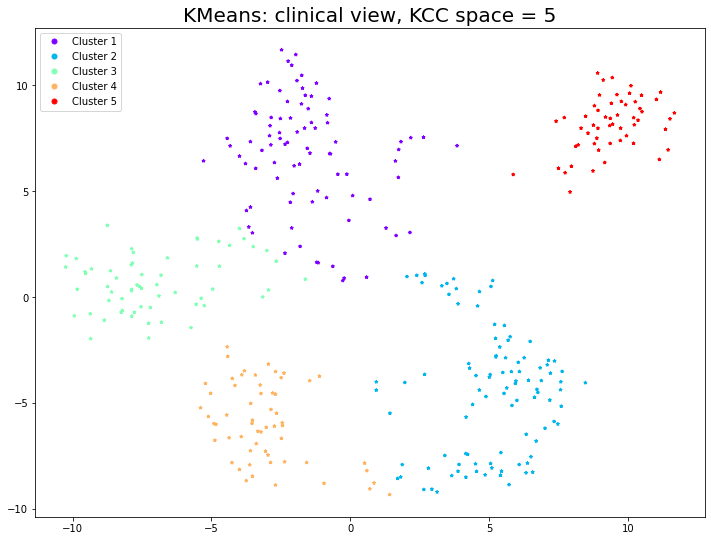

View                contextual
KCC_space                    3
TSNE                      True
perplexity                50.0
random_state               2.0
silhouette_score         0.728
Name: 43, dtype: object

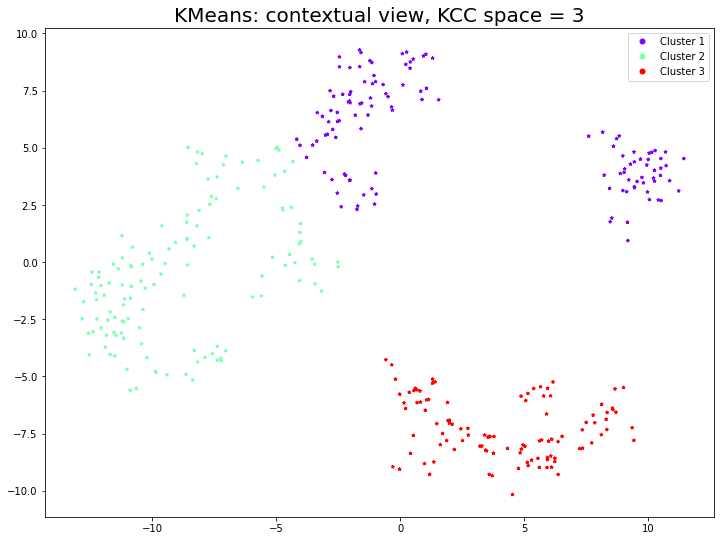

View                physio
KCC_space                4
TSNE                  True
perplexity            50.0
random_state           2.0
silhouette_score     0.556
Name: 94, dtype: object

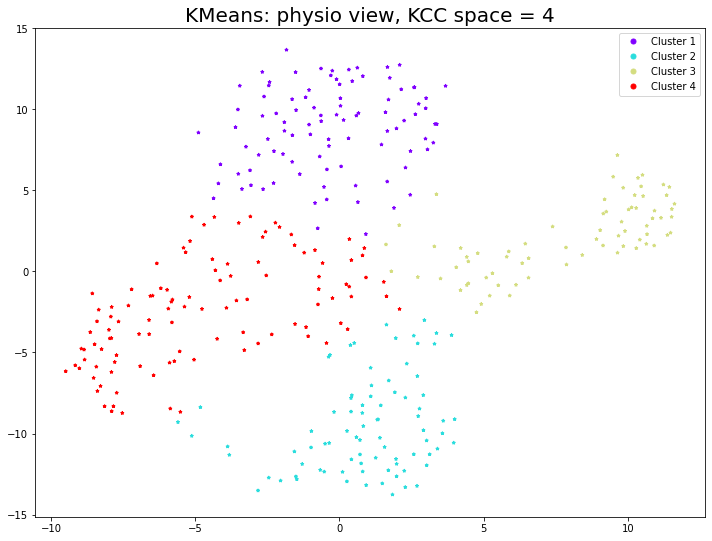

View                proteome
KCC_space                  5
TSNE                    True
perplexity              30.0
random_state             6.0
silhouette_score       0.628
Name: 139, dtype: object

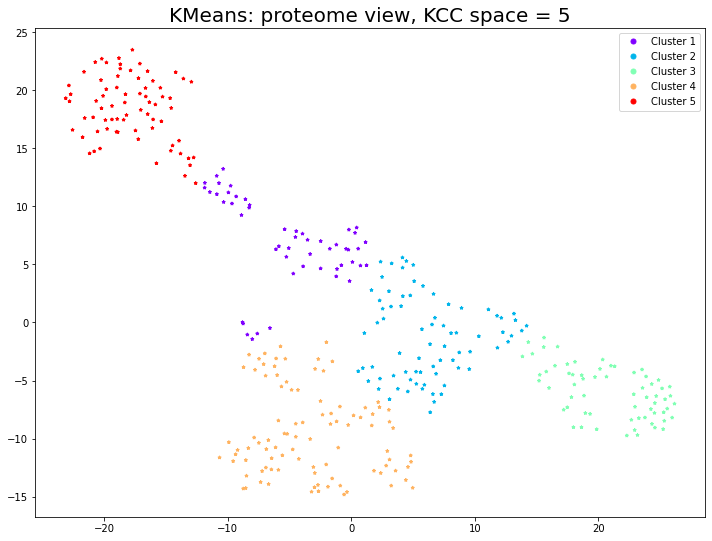

In [5]:
for view in ["clinical", "contextual", "physio", "proteome"]:
    report = pd.read_csv(
        "{}/ConsensusKMeans_{}_view.csv".format(score_path, view), index_col=0
    )
    report = report.sort_values("silhouette_score", ascending=False).iloc[0]
    KCC_space = report["KCC_space"]

    data = pd.read_csv(
        "{}/KCC_Cov_AgeGRM_{}_NormalImputation_K{}.csv".format(
            kcc_path, view, KCC_space
        ),
        header=None,
    )
    display(report)

    cons = ConsensusCluster(
        KMeans, KCC_space, KCC_space + 1, 100, resample_proportion=0.8
    )
    perplexity, random_state = int(report["perplexity"]), int(report["random_state"])
    tsne = TSNE(perplexity=perplexity, random_state=random_state, n_components=2)
    X_emb = tsne.fit_transform(data.values)
    assert X_emb.shape == (358, 2)
    cons.fit(pd.DataFrame(X_emb))
    assignment = cons.predict_data(X_emb) + 1

    plt.figure(figsize=(12, 9))
    legends = []
    cmap = cm.rainbow(np.linspace(0, 1, KCC_space))
    colors = np.array([cmap[i - 1] for i in assignment])
    for i in range(KCC_space):
        legends.append(
            mlines.Line2D(
                [],
                [],
                color=cmap[i],
                marker=".",
                linestyle="None",
                markersize=10,
                label="Cluster {}".format(i + 1),
            )
        )
    plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        color=colors,
        s=10,
        marker="*",
    )
    plt.title(
        "KMeans: {} view, KCC space = {}".format(view, KCC_space),
        fontsize=20,
    )
    plt.legend(handles=legends, fontsize=10)
    plt.savefig(
        "{}/ConsensusKMeans_{}_view_KCC_{}.png".format(tsne_path, view, KCC_space),
        dpi=300,
    )
    plt.show()

    X_emb = pd.DataFrame(X_emb, index=refer_id.index, columns=["TSNE 1", "TSNE_2"])
    X_emb.to_csv(
        "{}/ConsensusKMeans_{}_view_KCC_{}_TSNE_embeddings.csv".format(
            score_path, view, KCC_space
        )
    )

    assignment = pd.DataFrame(assignment, index=refer_id.index, columns=["assignment"])
    assignment.to_csv(
        "{}/ConsensusKMeans_{}_view_KCC_{}_assignments.csv".format(
            score_path, view, KCC_space
        )
    )

In [ ]:
view = 'clinical'
KCC_space = 4
plot_kmeans(view, KCC_space)

view = 'clinical'
KCC_space = 6
plot_kmeans(view, KCC_space)

view = 'contextual'
KCC_space = 4
plot_kmeans(view, KCC_space)

view = 'contextual'
KCC_space = 6
plot_kmeans(view, KCC_space)

view = 'physio'
KCC_space = 4
plot_kmeans(view, KCC_space)

view = 'physio'
KCC_space = 5
plot_kmeans(view, KCC_space)

view = 'proteome'
KCC_space = 4
plot_kmeans(view, KCC_space)

view = 'proteome'
KCC_space = 6
plot_kmeans(view, KCC_space)

# best DBSCAN case

View                clinical
KCC_space                  4
TSNE                    True
perplexity                30
random_state               1
eps                    3.333
min_samples               21
n_state                    0
silhouette_score       0.678
DBSCAN_clusters            5
outlier_ratio          0.047
Name: 3473, dtype: object


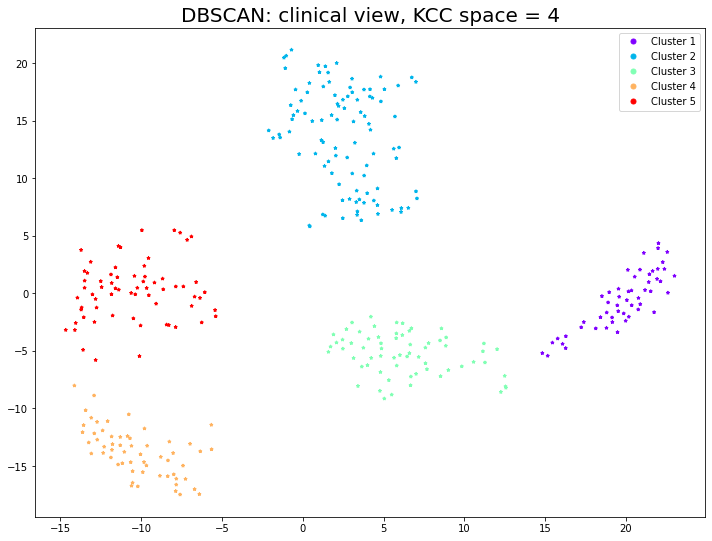

View                contextual
KCC_space                    6
TSNE                      True
perplexity                  30
random_state                 3
eps                      2.727
min_samples                 21
n_state                      0
silhouette_score         0.731
DBSCAN_clusters              7
outlier_ratio            0.034
Name: 14726, dtype: object


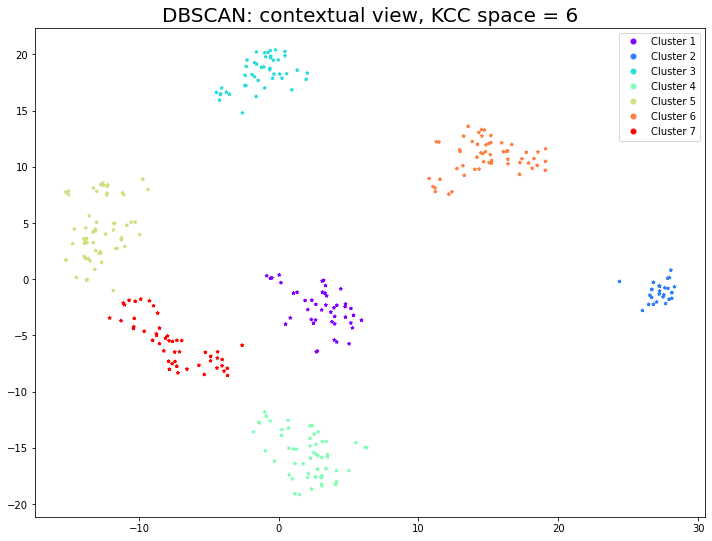

View                physio
KCC_space                4
TSNE                  True
perplexity              30
random_state             2
eps                  3.939
min_samples             21
n_state                  0
silhouette_score     0.574
DBSCAN_clusters          5
outlier_ratio        0.045
Name: 2554, dtype: object


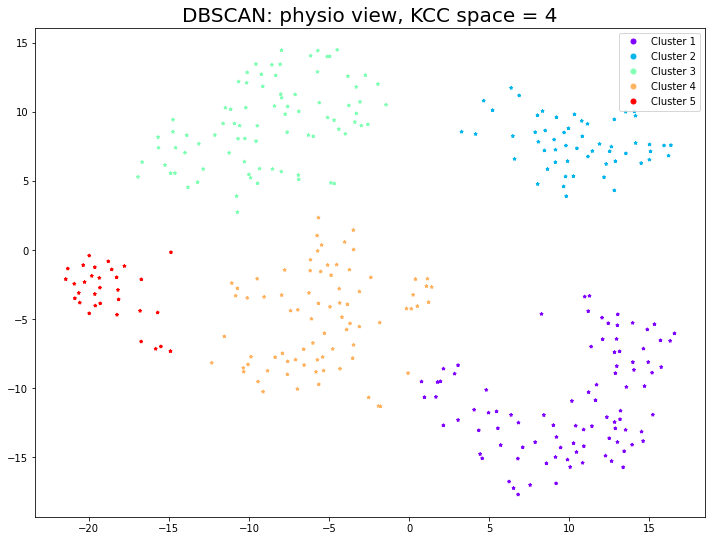

View                proteome
KCC_space                  5
TSNE                    True
perplexity                30
random_state               0
eps                    5.151
min_samples                7
n_state                    0
silhouette_score       0.734
DBSCAN_clusters            2
outlier_ratio            0.0
Name: 8598, dtype: object


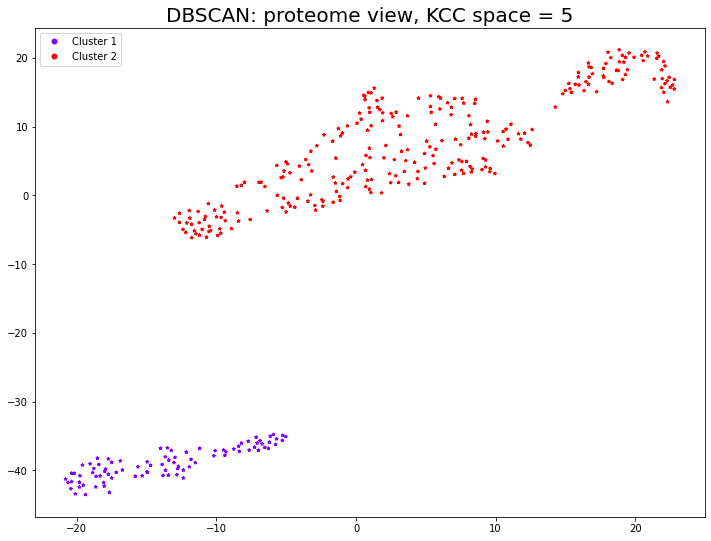

In [4]:
for view in ["clinical", "contextual", "physio", "proteome"]:
    report = pd.read_csv("{}/DBSCAN_{}_view.csv".format(score_path, view), index_col=0)
    report = report[report["outlier_ratio"] <= 0.05]
    report = report.sort_values("silhouette_score", ascending=False).iloc[0]
    KCC_space = report["KCC_space"]
    print(report)

    data = pd.read_csv(
        "{}/KCC_Cov_AgeGRM_{}_NormalImputation_K{}.csv".format(
            kcc_path, view, KCC_space
        ),
        header=None,
    )

    perplexity, random_state = int(report["perplexity"]), int(report["random_state"])
    eps, min_samples = report["eps"], report["min_samples"]
    tsne = TSNE(perplexity=perplexity, random_state=random_state, n_components=2)
    X_emb = tsne.fit_transform(data.values)
    cluster = DBSCAN(eps=eps, min_samples=min_samples)
    cluster.fit(X_emb)
    score = silhouette_score(
        X_emb[cluster.labels_ != -1],
        cluster.labels_[cluster.labels_ != -1],
    )
    TSNE_emb = pd.DataFrame(X_emb, index=refer_id.index, columns=["TSNE 1", "TSNE_2"])
    assignment = pd.DataFrame(
        cluster.labels_, index=refer_id.index, columns=["assignment"]
    )

    TSNE_emb.to_csv(
        "{}/DBSCAN_{}_view_KCC_{}_TSNE_embeddings.csv".format(
            score_path, view, KCC_space
        )
    )

    assignment.to_csv(
        "{}/DBSCAN_{}_view_KCC_{}_assignments.csv".format(score_path, view, KCC_space)
    )

    assignment = cluster.labels_

    X_emb_csv = pd.DataFrame(X_emb, index=refer_id.index, columns=["TSNE 1", "TSNE_2"])
    X_emb_csv.to_csv(
        "{}/DBSCAN_{}_view_KCC_{}_TSNE_embeddings.csv".format(
            score_path, view, KCC_space
        )
    )

    assignment_csv = pd.DataFrame(
        assignment, index=refer_id.index, columns=["assignment"]
    )
    assignment_csv.to_csv(
        "{}/DBSCAN_{}_view_KCC_{}_assignments.csv".format(score_path, view, KCC_space)
    )

    X_emb = X_emb[cluster.labels_ != -1]
    assignment = cluster.labels_[cluster.labels_ != -1]

    plt.figure(figsize=(12, 9))
    legends = []
    cmap = cm.rainbow(np.linspace(0, 1, len(np.unique(assignment))))
    colors = np.array([cmap[i - 1] for i in assignment])
    for i in range(len(np.unique(assignment))):
        legends.append(
            mlines.Line2D(
                [],
                [],
                color=cmap[i],
                marker=".",
                linestyle="None",
                markersize=10,
                label="Cluster {}".format(i + 1),
            )
        )

    plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        color=colors,
        s=10,
        marker="*",
    )
    plt.title(
        "DBSCAN: {} view, KCC space = {}".format(view, KCC_space),
        fontsize=20,
    )
    plt.legend(handles=legends, fontsize=10)
    plt.savefig(
        "{}/DBSCAN_{}_view_KCC_{}.png".format(tsne_path, view, KCC_space), dpi=300
    )
    plt.show()

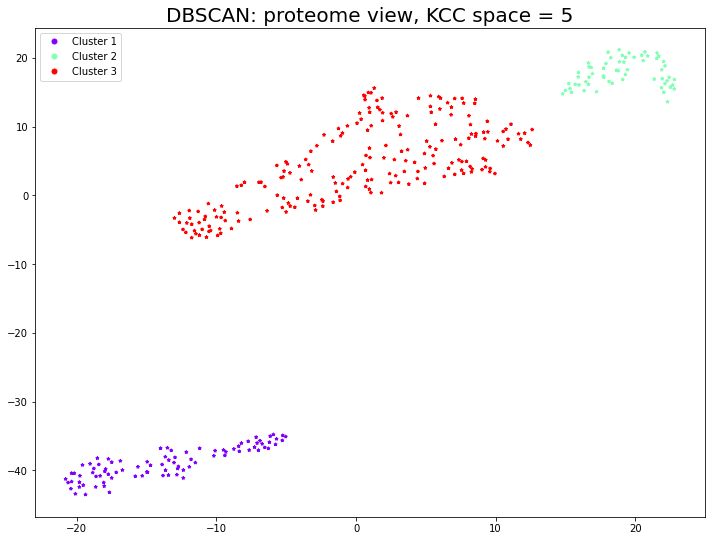

In [7]:
view = "proteome"
report = pd.read_csv("{}/DBSCAN_{}_view.csv".format(score_path, view), index_col=0)
report = report[report["outlier_ratio"] <= 0.05]
report = report[report["DBSCAN_clusters"] == 3]
report = report.sort_values("silhouette_score", ascending=False).iloc[0]
KCC_space = report['KCC_space']
data = pd.read_csv(
    "{}/KCC_Cov_AgeGRM_{}_NormalImputation_K{}.csv".format(kcc_path, view, KCC_space),
    header=None,
)

perplexity, random_state = int(report["perplexity"]), int(report["random_state"])
eps, min_samples = report["eps"], report["min_samples"]
tsne = TSNE(perplexity=perplexity, random_state=random_state, n_components=2)
X_emb = tsne.fit_transform(data.values)
cluster = DBSCAN(eps=eps, min_samples=min_samples)
cluster.fit(X_emb)
score = silhouette_score(
    X_emb[cluster.labels_ != -1],
    cluster.labels_[cluster.labels_ != -1],
)
TSNE_emb = pd.DataFrame(X_emb, index=refer_id.index, columns=["TSNE 1", "TSNE_2"])
assignment = pd.DataFrame(
    cluster.labels_, index=refer_id.index, columns=["assignment"]
)

TSNE_emb.to_csv(
    "{}/DBSCAN_{}_view_KCC_{}_TSNE_embeddings.csv".format(
        score_path, view, KCC_space
    )
)

assignment.to_csv(
    "{}/DBSCAN_{}_view_KCC_{}_assignments.csv".format(score_path, view, KCC_space)
)

X_emb = X_emb[cluster.labels_ != -1]
assignment = cluster.labels_[cluster.labels_ != -1]

plt.figure(figsize=(12, 9))
legends = []
cmap = cm.rainbow(np.linspace(0, 1, len(np.unique(assignment))))
colors = np.array([cmap[i - 1] for i in assignment])
for i in range(len(np.unique(assignment))):
    legends.append(
        mlines.Line2D(
            [],
            [],
            color=cmap[i],
            marker=".",
            linestyle="None",
            markersize=10,
            label="Cluster {}".format(i + 1),
        )
    )

plt.scatter(
    X_emb[:, 0],
    X_emb[:, 1],
    color=colors,
    s=10,
    marker="*",
)
plt.title(
    "DBSCAN: {} view, KCC space = {}".format(view, KCC_space),
    fontsize=20,
)
plt.legend(handles=legends, fontsize=10)
plt.show()



# selected views

In [28]:
configs = [
    ["clinical", 4, "DBSCAN"],
    ["contextual", 6, "DBSCAN"],
    ["physio", 4, "ConsensusKMeans"],
    ["proteome", 5, "DBSCAN"],
]
configs = [["physio", 4, "ConsensusKMeans"]]

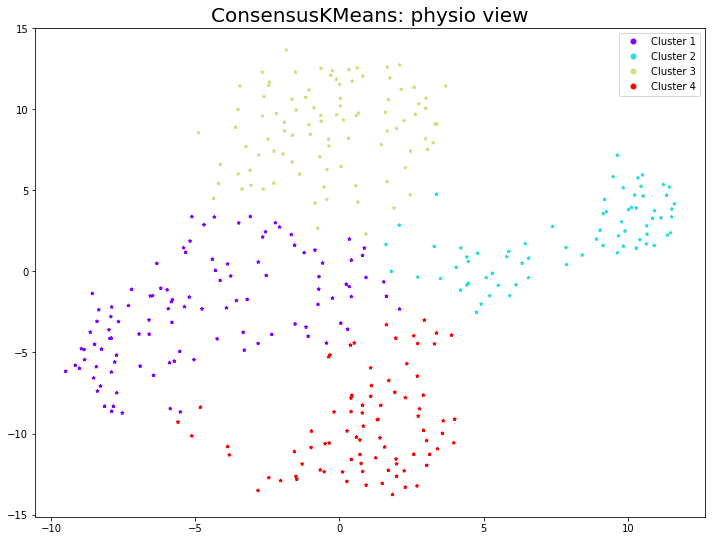

In [30]:
for config in configs:
    view, KCC_space, method = config
    X_emb = pd.read_csv(
        "{}/{}_{}_view_KCC_{}_TSNE_embeddings.csv".format(
            score_path, method, view, KCC_space
        ),
        index_col=0,
    )
    assignments = pd.read_csv(
        "{}/{}_{}_view_KCC_{}_assignments_ranked.csv".format(
            score_path, method, view, KCC_space
        ),
        index_col=0,
    )
    X_emb = X_emb[assignments["assignment"] != -1]
    assignments = assignments[assignments["assignment"] != -1]
    if method == "DBSCAN":
        assignments["assignment"] = assignments["assignment"] + 1

    plt.figure(figsize=(12, 9))
    legends = []
    cmap = cm.rainbow(np.linspace(0, 1, len(np.unique(assignments["assignment"]) +1)))
    colors = np.array([cmap[i - 1] for i in assignments["assignment"]])
    for i in range(len(assignments["assignment"].unique())):
        legends.append(
            mlines.Line2D(
                [],
                [],
                color=cmap[i],
                marker=".",
                linestyle="None",
                markersize=10,
                label="Cluster {}".format(i + 1),
            )
        )

    plt.scatter(
        X_emb.iloc[:, 0],
        X_emb.iloc[:, 1],
        color=colors,
        s=10,
        marker="*",
    )
    plt.title(
        "{}: {} view".format(method, view),
        fontsize=20,
    )
    plt.legend(handles=legends, fontsize=10)
    plt.savefig(
        "{}/{}_{}_view_KCC_{}.png".format(tsne_path, method, view, KCC_space), dpi=300
    )
    plt.show()

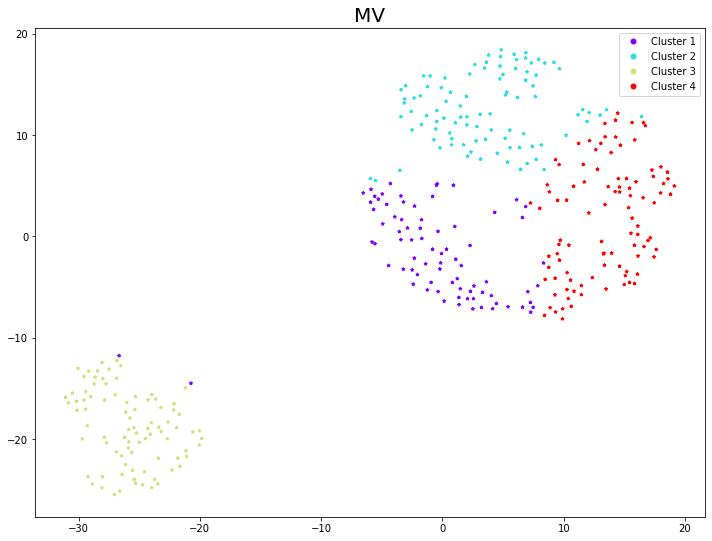

In [3]:
X_emb = pd.read_csv('data/MVKDR_results/proteome_clinical_K_4_projections.csv', index_col=0)
tsne = TSNE(
        perplexity=30, random_state=2, n_components=2
    )
X_emb = tsne.fit_transform(X_emb.values)
assignments = pd.read_csv('data/MVKDR_results/proteome_clinical_K_4_assignments_ranked.csv', index_col=0)
plt.figure(figsize=(12, 9))
legends = []
cmap = cm.rainbow(np.linspace(0, 1, len(np.unique(assignments["assignment"]) +1)))
colors = np.array([cmap[i - 1] for i in assignments["assignment"]])
for i in range(len(assignments["assignment"].unique())):
    legends.append(
        mlines.Line2D(
            [],
            [],
            color=cmap[i],
            marker=".",
            linestyle="None",
            markersize=10,
            label="Cluster {}".format(i + 1),
        )
    )

plt.scatter(
    X_emb[:, 0],
    X_emb[:, 1],
    color=colors,
    s=10,
    marker="*",
)
plt.title(
    "MV",
    fontsize=20,
)
plt.legend(handles=legends, fontsize=10)
plt.savefig(
    "{}/MV_proteome_clinical.png".format(tsne_path), dpi=300
)
plt.show()